In [3]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import gcmpyo3

from core.amp.likelihood import probit_likelihood
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
import core.erm.logistic_regression as logistic_regression
from core.utility import KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, sigmoid, build_gcm_from_activation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
d         = 200
seeds     = 30

n_over_d  = 2.0 
noise_std = 0.5
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [16]:
inv_alpha_range  = np.array([0.1, 0.14949494949494951, 0.198989898989899, 0.24848484848484848, 0.297979797979798, 0.3474747474747475, 0.396969696969697, 0.44646464646464656, 0.495959595959596, 0.5454545454545455, 0.5949494949494949, 0.6444444444444445, 0.693939393939394, 0.7434343434343434, 0.7929292929292932, 0.8424242424242424, 0.891919191919192, 0.9414141414141416, 0.990909090909091, 1.0404040404040404, 1.0898989898989901, 1.1393939393939396, 1.188888888888889, 1.2383838383838386, 1.287878787878788, 1.3373737373737375, 1.386868686868687, 1.4363636363636367, 1.4858585858585862, 1.5353535353535357, 1.5848484848484852, 1.6343434343434347, 1.6838383838383841, 1.7333333333333334, 1.782828282828283, 1.8323232323232326, 1.881818181818182, 1.9313131313131315, 1.9808080808080812, 2.0303030303030307, 2.0797979797979806, 2.1292929292929297, 2.178787878787879, 2.2282828282828286, 2.277777777777778, 2.327272727272728, 2.376767676767677, 2.4262626262626266, 2.4757575757575765, 2.525252525252526, 2.5747474747474755, 2.624242424242425, 2.6737373737373744, 2.7232323232323234, 2.772727272727274, 2.8222222222222233, 2.8717171717171723, 2.921212121212122, 2.9707070707070717, 3.020202020202021, 3.06969696969697, 3.11919191919192, 3.168686868686869, 3.2181818181818187, 3.267676767676768, 3.3171717171717177, 3.366666666666668, 3.416161616161617, 3.465656565656567, 3.5151515151515156, 3.564646464646465, 3.6141414141414154, 3.663636363636365, 3.713131313131313, 3.7626262626262625, 3.812121212121213, 3.8616161616161624, 3.911111111111112, 3.9606060606060622, 4.010101010101011, 4.05959595959596, 4.10909090909091, 4.158585858585859, 4.208080808080809, 4.257575757575759, 4.307070707070707, 4.356565656565657, 4.406060606060607, 4.455555555555557, 4.505050505050505, 4.5545454545454565, 4.604040404040404, 4.653535353535354, 4.703030303030304, 4.752525252525253, 4.802020202020202, 4.851515151515152, 4.901010101010103, 4.950505050505051, 5.0])
erm_lambda_error = np.array([4.032520108805756, 2.769521713633513, 2.143561830742072, 1.7733700837521102, 1.530940661432904, 1.3611812124967675, 1.2364819708287826, 1.1415025863362342, 1.067063268492194, 1.0073598449189478, 0.9585562331084208, 0.9180250032051878, 0.8839085603628344, 0.8548576792199934, 0.8298690533865783, 0.8081821605867189, 0.7892102241801638, 0.772493950340956, 0.7576696428415695, 0.7444455663397825, 0.7325851050220566, 0.7218955139885023, 0.7122172318973965, 0.7034180699318692, 0.6953868819657548, 0.6880309030115057, 0.6812702009449265, 0.6750379595192608, 0.6692759016570834, 0.6639340736152693, 0.6589693384492085, 0.6543440800245645, 0.6500254832247956, 0.6459845940825736, 0.6421961210753289, 0.6386375546441942, 0.6352890015836326, 0.6321326971171474, 0.6291529889415162, 0.6263355638666203, 0.6236680050387524, 0.6211385441779284, 0.6187369716155668, 0.6164542675539131, 0.6142817641105698, 0.6122116155111764, 0.6102370501226964, 0.6083516608797263, 0.6065493926968278, 0.6048253478593895, 0.6031745478530988, 0.6015921836558182, 0.6000742205102487, 0.5986169980307957, 0.5972168387177729, 0.5958706440922131, 0.5945753177080773, 0.5933278128449517, 0.592125943340715, 0.5909671400406589, 0.5898490051377139, 0.5887697570429633, 0.5877271766703795, 0.5867194091310942, 0.5857448851750183, 0.5848019497413075, 0.5838892674767775, 0.5830051174096134, 0.5821484256908523, 0.5813177516093314, 0.5805120877171449, 0.5797301327311144, 0.578971326605644, 0.5782341993000988, 0.5775180293849939, 0.5768219270050272, 0.5761448256838914, 0.5754864904178701, 0.5748455852737776, 0.5742220457257563, 0.5736146398109053, 0.5730226567689976, 0.5724461967849547, 0.5718842267097863, 0.5713360273550983, 0.5708015270778893, 0.5702800714123972, 0.569770987001327, 0.5692740239557904, 0.5687887557678797, 0.5683147252958137, 0.5678516337812037, 0.5673990626990517, 0.566956587975199, 0.5665238982920905, 0.5661006699628314, 0.5656868498257728, 0.5652816771365086, 0.5648852979425655, 0.5644972029684925])

index = [ i for i in range(0, len(inv_alpha_range), 5) if 4.5 >= inv_alpha_range[i] >= 0.5 ]
inv_alpha_range = inv_alpha_range[index]
erm_lambda_error = erm_lambda_error[index]
n_alpha = len(inv_alpha_range)

In [17]:
max_p        = int(n_over_d * d * inv_alpha_range[-1])
F_global     = np.random.normal(0.0, 1.0, size=(max_p, d)) / np.sqrt(d)

In [18]:
def generate_logit_data(kappa1, kappastar, F, n, teacher_dim, student_dim, noise_std, wstar = None):
    if wstar is None:
        wstar = np.random.normal(0.0, 1.0, size=teacher_dim)
        wstar = wstar * np.sqrt(teacher_dim) / np.linalg.norm(wstar)

    X0 = np.random.normal(0.0, 1.0, size=(n, teacher_dim))
    V  = kappa1 * X0 @ F.T  + kappastar * np.random.normal(0.0, 1.0, size=(n, student_dim))
    Y = 2.0 * np.random.binomial(1.0, p = sigmoid(X0 @ wstar / np.sqrt(teacher_dim) + noise_std * np.random.normal(0.0, 1.0, size=n)) ) - 1.0
    return wstar, V / np.sqrt(student_dim), Y

In [19]:
def inv_hessian(w, X, Y, lambda_):
    p = len(w)
    D = np.diag([sigmoid(w @ x) * (1.0 - sigmoid(w @ x)) for x in X])
    hessian     = X.T @ D @ X + lambda_ * np.eye(p)
    return np.linalg.inv(hessian)

def inv_hessian_trace(w, X, Y, lambda_, Omega):
    p = len(w)
    return np.trace(inv_hessian(w, X, Y, lambda_) @ Omega / p)

In [20]:
def trial(d, n_over_d, inv_alpha_range, erm_lambda_error):
    hessian_list, m_list, q_list = [], [], [] 

    for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, erm_lambda_error)):
        alpha = 1.0 / inv_alpha
        gamma = n_over_d * inv_alpha
        # student_dim 
        p     = int(gamma * d)
        
        # build the matrices / covariance matrices
        F = F_global[:p]
        wstar, X, Y = generate_logit_data(kappa1, kappastar, F, n, d, p, noise_std)
        
        what     = logistic_regression.solve_logistic_regression(X, Y, lambda_)

        Omega    = kappa1**2 * F @ F.T + kappastar**2 * np.eye(p)
        m_list.append(kappa1 * wstar @ F.T @ what / np.sqrt(p * d))
        q_list.append(what @ Omega @ what / p)
        hessian_list.append( inv_hessian_trace(what, X, Y, lambda_, Omega) )

    return m_list, q_list, hessian_list

In [26]:
hessian_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))
for s in range(seeds):
    try:
        m_list, q_list, hessian_list = trial(d, n_over_d, inv_alpha_range, erm_lambda_error)
        q_array[s] = q_list
        m_array[s] = m_list
        hessian_array[s] = hessian_list
    except Exception as e:
        print(e)
        q_array[s] = q_array[s-1]
        m_array[s] = m_array[s-1]
        hessian_array[s] = hessian_array[s-1]

16it [00:21,  1.37s/it]
16it [00:21,  1.36s/it]
16it [00:21,  1.32s/it]
16it [00:21,  1.33s/it]
16it [00:23,  1.45s/it]
16it [00:24,  1.54s/it]
16it [00:24,  1.52s/it]
16it [00:22,  1.38s/it]
16it [00:22,  1.43s/it]
16it [00:22,  1.39s/it]
16it [00:20,  1.26s/it]
16it [00:23,  1.45s/it]
16it [00:22,  1.38s/it]
16it [00:21,  1.33s/it]
16it [00:22,  1.42s/it]
16it [00:23,  1.45s/it]
16it [00:21,  1.34s/it]
16it [00:20,  1.31s/it]
16it [00:21,  1.34s/it]
16it [00:20,  1.29s/it]
16it [01:38,  6.14s/it]
16it [01:24,  5.26s/it]
16it [01:37,  6.08s/it]
16it [00:32,  2.04s/it]
16it [26:35, 99.71s/it] 
16it [00:29,  1.85s/it]
16it [00:24,  1.53s/it]
16it [00:24,  1.55s/it]
16it [00:22,  1.40s/it]
16it [00:21,  1.33s/it]


In [27]:
m_list = np.mean(m_array, axis=0)
q_list = np.mean(q_array, axis=0)
hessian_list = np.mean(hessian_array, axis=0)

In [23]:
qs_for_erm_loss = []
ms_for_erm_loss = []


for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, erm_lambda_error)):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, lambda_, 1.0, "logit", 1e-6, False)
    qs_for_erm_loss.append(q)
    ms_for_erm_loss.append(m)

16it [00:00, 27.10it/s]


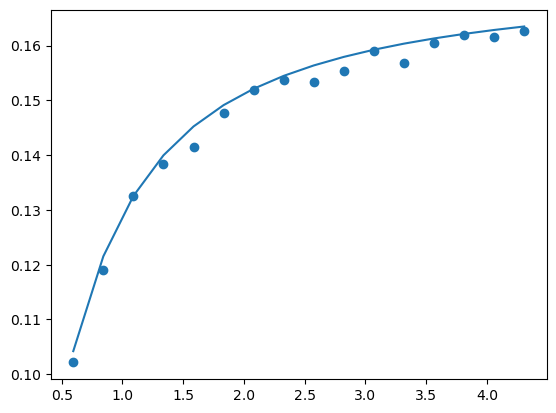

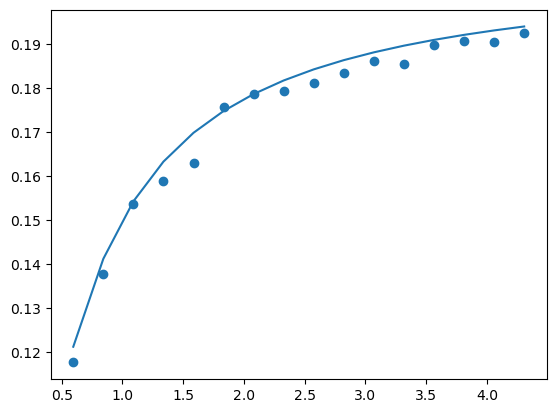

In [28]:
plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, np.array(qs_for_erm_loss))
plt.show()

plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, np.array(ms_for_erm_loss))
plt.show()

In [32]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of the Hessian trace : ')
print(list(hessian_list))

[0.5949494949494949, 0.8424242424242424, 1.0898989898989901, 1.3373737373737375, 1.5848484848484852, 1.8323232323232326, 2.0797979797979806, 2.327272727272728, 2.5747474747474755, 2.8222222222222233, 3.06969696969697, 3.3171717171717177, 3.564646464646465, 3.812121212121213, 4.05959595959596, 4.307070707070707]
[0.11768206029666747, 0.13777295972300355, 0.15372915792492642, 0.1588821664586818, 0.16285717413208273, 0.17561879114652162, 0.17856809570411383, 0.1793060916409111, 0.18112218884260262, 0.18332648962639955, 0.18603816386406172, 0.18554490939114973, 0.18966087298723053, 0.19065137018318346, 0.19037188472090072, 0.19248571611475873]
q
[0.10214930974976481, 0.11911023149466059, 0.13258749915634482, 0.1384440971859609, 0.14144178185690395, 0.1476178400393094, 0.15188789092429522, 0.15369964937966582, 0.15332764089137882, 0.15534234389978463, 0.1589887181484939, 0.15690314508735473, 0.16042497943030087, 0.16193520249095467, 0.1616486586127556, 0.16266947820727637]
hessian
[0.361574